# Tentando entender o que afeta os coeficientes da regress√£o log√≠stica

Ver o impacto de um fator multiplicativo em uma vari√°vel de entrada e de ru√≠do

#### Meu pensamento inicial:
> - fator multiplicativo afeta coeficientes (ex.: conver√ß√£o de moeda: R$->US$)
> - ru√≠do n√£o afeta os coeficientes*

*assumindo que a m√©dia do ru√≠do √© zero e for√ßando que o ru√≠do n√£o desnormalize os dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
sns.set()

In [2]:
# Fun√ß√£o para aplicar o ru√≠do
def aplly_noise(noise_intensity=1):
  def func(input):
    noise_amplitude = noise_intensity*math.sin(input*math.pi)/4
    noise = np.random.uniform(-noise_amplitude,noise_amplitude)
    return input+noise
  return func

In [3]:
# "intensidade" dos ru√≠dos
noise_levels = {
  'noised_a': 0.33333,
  'noised_b': 0.66667,
  'noised_c': 1,
}

# dataframe com entrada pura, com diferentes n√≠veis de ru√≠do, entrada aleat√≥ria e sa√≠da esperada
df = pd.DataFrame()
df['inputs'] = np.linspace(0,1,10000)
df['noised_a'] = df['inputs'].map(aplly_noise(noise_levels['noised_a']))
df['noised_b'] = df['inputs'].map(aplly_noise(noise_levels['noised_b']))
df['noised_c'] = df['inputs'].map(aplly_noise(noise_levels['noised_c']))
df['random'] = np.random.uniform(0,1, len(df['inputs']))
df['outputs'] = df['inputs'].map(lambda input: 0 if input<0.5 else 1)

# primeiras e ultimas linhas para ilustrar
df.take([0,1,-2,-1])

inputs  noised_a  noised_b  noised_c    random  outputs
0     0.0000  0.000000  0.000000  0.000000  0.946940        0
1     0.0001  0.000094  0.000150  0.000024  0.524170        0
9998  0.9999  0.999921  0.999863  0.999880  0.643847        1
9999  1.0000  1.000000  1.000000  1.000000  0.401324        1

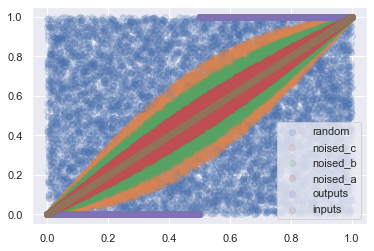

In [4]:
# Dispers√£o de todas as colunas do dataframe

fig, ax = plt.subplots()
ax.scatter(x=df.inputs, y=df.random, label="random", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_c, label="noised_c", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_b, label="noised_b", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_a, label="noised_a", alpha=.15)
ax.scatter(x=df.inputs, y=df.outputs, label="outputs", alpha=.15)
ax.scatter(x=df.inputs, y=df.inputs, label="inputs", alpha=.15)
ax.legend()

# ü§î Pra que tudo isso?
- `inputs`: entrada ideal para determinar os `outputs`
- `noised_X`: varia√ß√µes do `inputs` com algum ru√≠do. Ru√≠do se intensifica apenas no centro para evitar a "desnormaliza√ß√£o" dos dados (mesmo com o ru√≠do, tudo fica entre 0 e 1)
- `inputs`: entrada aleat√≥ria que n√£o deve apresentar correla√ß√£o com `outputs`

### Regrass√£o com `inputs`:

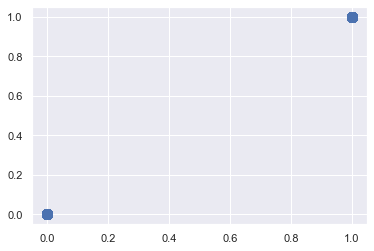

In [5]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, s=100)

> regress√£o perfeita, nenhum falso positivo ou falso negativo

### Regrass√£o com `noised_a`:

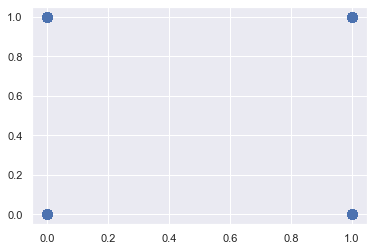

In [6]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

noised_a_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, alpha=0.01, s=100)

> regress√£o imperfeita, alguns falsos positivos e falsos negativos

# Comparando os coeficientes isolados

In [7]:
print('input_coefs:',input_coefs)
print('noised_a_coefs:',noised_a_coefs)

input_coefs: (25.430619174690186, -12.71529402057659)
noised_a_coefs: (22.090708163825518, -11.054263514637857)


### Conclus√£o1: Meu pensamento inicial estava errado.
O ruido afetou o coeficiente

# Vendo os coeficientes usando todas as vari√°veis

In [8]:
X = df[['inputs','noised_a','noised_b','noised_c','random']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

original_coefs = pd.DataFrame(clf.coef_, columns=X.columns)
original_coefs['intercept'] = clf.intercept_[0]
original_coefs

inputs  noised_a  noised_b  noised_c    random  intercept
0  16.553599  10.32513  5.008576  2.324114  0.194574 -17.200845

# Vendo o efeito do fator multiplicativo em uma das entradas

In [9]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*2)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

coefs = pd.DataFrame(clf.coef_, columns=X.columns)
coefs['intercept'] = clf.intercept_[0]

print("Original:")
print(original_coefs)
print('\n')
print("noised_a multiplicado:")
print(coefs)

Original:
      inputs  noised_a  noised_b  noised_c    random  intercept
0  16.553599  10.32513  5.008576  2.324114  0.194574 -17.200845


noised_a multiplicado:
     inputs  noised_a  noised_b  noised_c    random  intercept
0  14.19871  8.848169  4.810651  2.293088  0.165465 -19.579853


### Conclus√£o: N√£o consegui concluir nada üò•
Todos os coeficientes v√£o mudando, o que j√° complica um pouco e tem o intercept ( = $\beta_0$?) que tamb√©m muda. N√£o consegui entender o padr√£o, o comportamento parece completamente diferente quando o fator multiplicaivo √©: 2, 5, 10 e 100

# Tentando for√ßar o aumento do coeficiente `noised_a` com fator multiplicativo:
- Spoiler: N√£o consegui fazer o coeficiente de `noised_a` superar o de `inputs`, mesmo multiplicando as entradas por um valor elevado (mas se em vez disso tivesse tentado reduzir o `inputs` daria certo)

- <strong style="color:#ff4545">Mas era pra conseguir, n√£o era?</strong>

In [10]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*10)     # N√£o deu
# X['noised_a'] = X['noised_a'].map(lambda vals: vals/10)     # Tbm n√£o deu
# X['inputs'] = X['inputs'].map(lambda vals: vals/100)          # Esse deu
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

coefs = pd.DataFrame(clf.coef_, columns=X.columns)
coefs['intercept'] = clf.intercept_[0]

print("Original:")
print(original_coefs)
print('\n')
print("noised_a multiplicado:")
print(coefs)

Original:
      inputs  noised_a  noised_b  noised_c    random  intercept
0  16.553599  10.32513  5.008576  2.324114  0.194574 -17.200845


noised_a multiplicado:
      inputs  noised_a  noised_b  noised_c    random  intercept
0  12.547106  2.511732  4.773521   2.34036  0.142777 -22.458019


# Vendo o efeito do fator multiplicativo em uma das entradas em casos isolados

In [11]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])

In [12]:
X = df[['noised_a']].copy()
X['noised_a'] = X['noised_a']*2
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_2 = (clf.coef_[0][0], clf.intercept_[0])

In [13]:
X = df[['noised_a']].copy()
X['noised_a'] = X['noised_a']/2
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_3 = (clf.coef_[0][0], clf.intercept_[0])

#### Comparando os coeficientes

In [14]:
print("Entrada dividida:",input_coefs_3)
print("Com entrada original:",input_coefs)
print("Entrada multiplicada:",input_coefs_2)

Entrada dividida: (30.09142713541245, -7.532492884442911)
Com entrada original: (22.090708163825518, -11.054263514637857)
Entrada multiplicada: (14.802768836729902, -14.810382746984896)


# Conclus√£o: ü§∑
Havia me esquecido que, al√©m do $\beta_1$, tamb√©m tinha o $\beta_0$ para ser considerado.

Pra esse caso isolado as coisas parecem fazer mais sentido, a "entrada dividida" acaba tendo coeficiente menor pois uma varia√ß√£o menor na entrada resulta numa altera√ß√£o maior esperada pro c√°lculo da sa√≠da (eu acho)